### I - Importing needed libraries

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path
import tensorflow as tf
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import os

### II - Downloading data 

In [2]:
# Download historical stock data for a specific ticker
ticker = 'AAPL'
stock_data = yf.download(ticker, interval='1h', start='2023-03-08', end='2025-03-06')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
display(stock_data)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,
2023-03-08 14:30:00+00:00,152.639206,153.100006,151.830002,152.809998,12650535
2023-03-08 15:30:00+00:00,152.589996,153.210007,152.330002,152.639999,5894074
2023-03-08 16:30:00+00:00,152.750000,153.470001,152.350006,152.600006,5428318
2023-03-08 17:30:00+00:00,152.335007,153.054993,152.250000,152.729996,4530420
2023-03-08 18:30:00+00:00,152.800003,152.809998,152.050003,152.339996,3976027
...,...,...,...,...,...
2025-03-05 16:30:00+00:00,234.539902,234.649994,229.229996,230.619995,5831367
2025-03-05 17:30:00+00:00,234.679993,235.539993,234.000000,234.539993,3887648


### III - Evaluating LSTM model

In [4]:
features = stock_data[['High', 'Low', 'Close', 'Volume']]
target = stock_data['Close']  # Predicting next time step close price

In [5]:
scaler = MinMaxScaler()

In [6]:
features_scaled = scaler.fit_transform(features)

In [7]:
target_reshaped = target.values.reshape(-1, 1)

In [8]:
target_scaled = scaler.fit_transform(target_reshaped)

In [9]:
x = []
y = []
time_steps = 7

for i in range(time_steps, len(features_scaled)):
    x.append(features_scaled[i-time_steps:i])
    y.append(target_scaled[i])

X, y = np.array(x), np.array(y)

In [10]:
# Function to build and train a Long Short Term Memory Deep Learning memory
def build_model(X_train, y_train, verbose):
    model = Sequential()
    # Use Input layer to specify the shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    # Add LSTM layer
    model.add(LSTM(units=64, activation='relu'))
    # Output layer
    model.add(Dense(1))  # For regression (1 output)
    # Print model summary
    model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fit the model with the training data
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3, verbose=verbose)

    return model

In [11]:
# Set up TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # 5 folds

loss_array, mae_array, mse_array, rmse_array = [], [], [], []

# Initialize the cross-validation loop
for k, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Running for {k}-fold")

    print(f"Spliting data...")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Building model...")
    model = build_model(X_train, y_train, verbose=0)
    
    print(f"Evaluating model...")
    loss = model.evaluate(X_test, y_test)
    loss_array.append(loss)

    print(f"Making predictions...")
    predictions_scaled = model.predict(X_test)
    predictions_reshaped = predictions_scaled.reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions_reshaped)
    actuals = scaler.inverse_transform(y_test)
    
    print(f"Calculate Error Metrics...")
    mse = mean_squared_error(actuals, predictions)
    mse_array.append(mse)
    mae = mean_absolute_error(actuals, predictions)
    mae_array.append(mae)
    rmse = np.sqrt(mse)
    rmse_array.append(rmse)
    print()
    
print("Final Evaluation Result")
print(f'Average Loss: {np.mean(loss_array)}')
print(f'Average Mean Absolute Error (MAE): {np.mean(mae_array)}')
print(f'Average Mean Squared Error (MSE): {np.mean(mse)}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse)}')

Running for 1-fold
Spliting data...
Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Evaluating model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0261e-04 
Making predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Calculate Error Metrics...

Running for 2-fold
Spliting data...
Building model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Evaluating model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2574e-05 
Making predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Calculate Error Metrics...

Running for 3-fold
Spliting data...
Building model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Evaluating model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5881e-04
Making predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Calculate Error Metrics...

Running for 4-fold
Spliting data...
Building model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Evaluating model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7632e-04 
Making predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Calculate Error Metrics...

Running for 5-fold
Spliting data...
Building model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Evaluating model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1025e-04 
Making predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Calculate Error Metrics...

Final Evaluation Result
Average Loss: 0.0002618463564431295
Average Mean Absolute Error (MAE): 1.3132430924676277
Average Mean Squared Error (MSE): 6.64159702961365
Average Root Mean Squared Error (RMSE): 2.5771296105577712


### IV - Testing & Simulating

In [12]:
train_test_separation_index = int(len(stock_data)*0.8)

print(f"{train_test_separation_index = }")

train_test_separation_index = 2784


In [13]:
X_train, y_train = X[:train_test_separation_index], y[:train_test_separation_index]
X_test, y_test = X[train_test_separation_index:], y[train_test_separation_index:]

In [14]:
model = build_model(X_train, y_train, verbose=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0261 - val_loss: 0.0015
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3431e-04 - val_loss: 6.5351e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6010e-04 - val_loss: 6.6404e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5151e-04 - val_loss: 6.9668e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5182e-04 - val_loss: 4.6998e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5921e-04 - val_loss: 4.7896e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5515e-04 - val_loss: 4.9198e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3327e-04 - val_loss: 4.8512e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3568e-04 - val_loss: 4.6036e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3812e-04 - val_loss: 4.5332e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3853e-04 - val_loss: 4.1

In [15]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4436e-04
Test Loss: 0.0002042904670815915


In [16]:
# Make predictions
predictions_scaled = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [17]:
# reshape predictions
predictions_reshaped = predictions_scaled.reshape(-1, 1)

In [18]:
predictions = scaler.inverse_transform(predictions_reshaped)

In [19]:
actuals = scaler.inverse_transform(y_test)

In [20]:
# Calculate Error Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate errors
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MSE: 2.525230123917268
MAE: 1.1182864207141796
RMSE: 1.5890972669781005


In [21]:
print(predictions[0])
predictions_add_rmse = predictions + rmse
print(predictions_add_rmse[0])

[228.81903]
[230.40812803]


In [22]:
def plot_actual_vs_predicted(actuals, predictions_add_rmse):
    # Plot Predictions vs Actual values
    plt.figure(figsize=(10,6))
    plt.plot(actuals, label='Actual', color="green")
    plt.plot(predictions_add_rmse, label='Predicted', color="blue")
    plt.grid(True)
    plt.title('Actual vs Predicted')
    plt.xlabel('Sequential Day Number')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

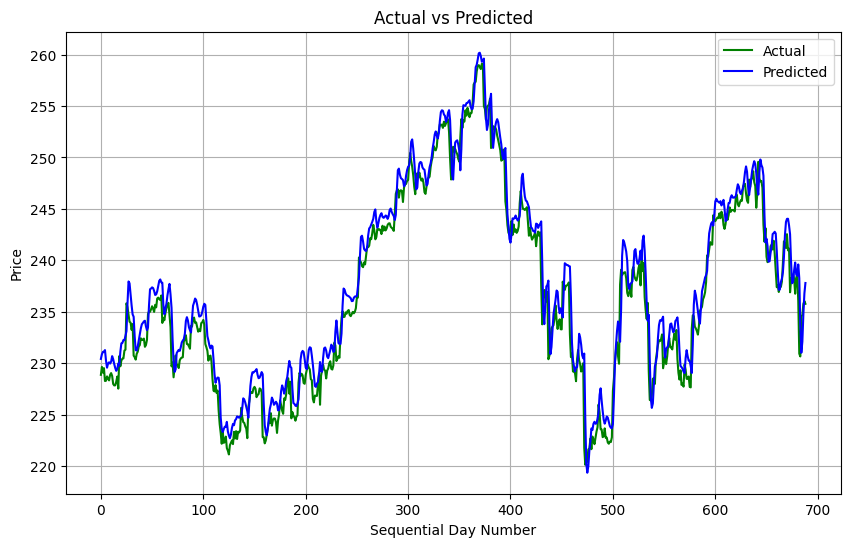

In [23]:
plot_actual_vs_predicted(
    actuals=actuals, 
    predictions_add_rmse=predictions_add_rmse
)

In [24]:
def plot_error_distribution(actuals, predictions_add_rmse):
    # Plot Error Distribution
    errors = actuals - predictions_add_rmse
    plt.figure(figsize=(10,6))
    plt.hist(errors, bins=50)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

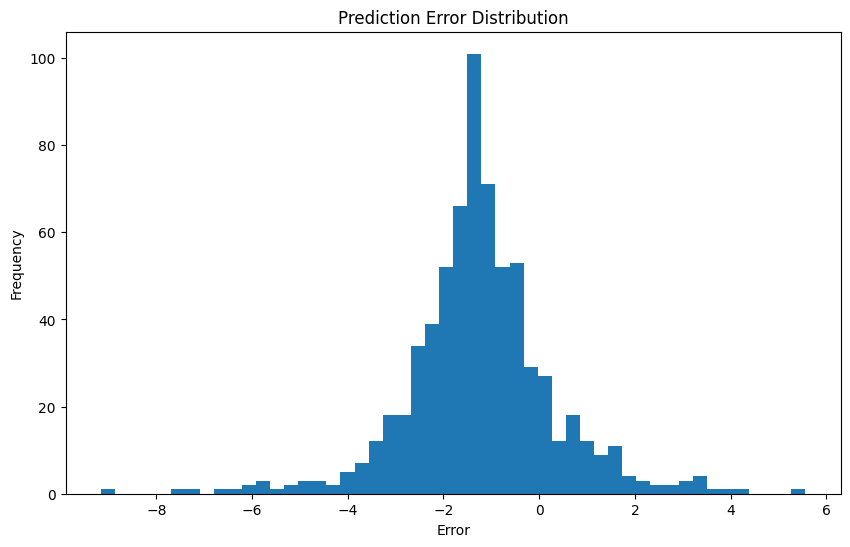

In [25]:
plot_error_distribution(
    actuals=actuals, 
    predictions_add_rmse=predictions_add_rmse
)

In [26]:
states = []

for index in range(1, len(predictions_add_rmse)):
    prev_actual = actuals[index-1][0]
    current_actual = actuals[index][0]
    actual_state = "Equal"
    if current_actual > prev_actual:
        actual_state = "Up"
    elif current_actual < prev_actual:
        actual_state = "Down"
    
    prev_prediction = predictions_add_rmse[index-1][0]
    current_prediction = predictions_add_rmse[index][0]
    prediction_state = "Equal"
    if current_prediction > prev_prediction:
        prediction_state = "Up"
    elif current_prediction < prev_prediction:
        prediction_state = "Down"

    state = {
        "prev_actual": prev_actual,
        "actual_state": actual_state,
        "current_actual": current_actual,

        "prev_prediction": prev_prediction,
        "prediction_state": prediction_state,
        "current_prediction": current_prediction,
    }
    states.append(state)

In [27]:
correctly_predicted = 0
up_predicted_actual_down = 0
up_predicted_actual_equal = 0
down_predicted_actual_up = 0
down_predicted_actual_equal = 0

def simulate_buy(stock_value, account_balance, current_price):
    units_afforded = account_balance/current_price
    buy_amount = units_afforded*current_price
    new_account_balance = account_balance - buy_amount
    new_stock_value = stock_value + units_afforded
    return new_account_balance, new_stock_value

def simulate_sell(stock_value, account_balance, current_price):
    after_sale_amount = stock_value*current_price
    new_stock_value = 0
    new_account_balance = account_balance + after_sale_amount
    return new_account_balance, new_stock_value
    
stock_value, account_balance = 0, 100
for index in range(len(states)):
    actual_state = states[index]["actual_state"]
    prediction_state = states[index]["prediction_state"]
    
    if actual_state == prediction_state and prediction_state == "Up":
        correctly_predicted += 1
        # Buy (Should win money)
        account_balance, stock_value = simulate_buy(
            stock_value=stock_value, 
            account_balance=account_balance, 
            current_price=states[index]["prev_actual"]
        )
        
    elif actual_state == prediction_state and prediction_state == "Down":
        correctly_predicted += 1
        # Sell (Should win money)
        account_balance, stock_value = simulate_sell(
            stock_value=stock_value, 
            account_balance=account_balance, 
            current_price=states[index]["prev_actual"]
        )

    elif actual_state == prediction_state and actual_state == "Equal":
        correctly_predicted += 1
        # do nothing
        
    elif actual_state != prediction_state:
        if prediction_state == "Up" and actual_state == "Down":
            up_predicted_actual_down += 1
            # Sell (Should lose money)
            account_balance, stock_value = simulate_buy(
                stock_value=stock_value, 
                account_balance=account_balance, 
                current_price=states[index]["prev_actual"]
            )
            
        elif prediction_state == "Up" and actual_state == "Equal":
            up_predicted_actual_equal += 1
            # Buy (No effect)
            account_balance, stock_value = simulate_buy(
                stock_value=stock_value, 
                account_balance=account_balance, 
                current_price=states[index]["prev_actual"]
            )
            
        elif prediction_state == "Down" and actual_state == "Up":
            down_predicted_actual_up += 1
            # Sell (Should lose money)
            account_balance, stock_value = simulate_sell(
                stock_value=stock_value, 
                account_balance=account_balance, 
                current_price=states[index]["prev_actual"]
            )

        elif prediction_state == "Down" and actual_state == "Equal":
            down_predicted_actual_equal += 1
            # Sell (Should lose money or no effect)
            account_balance, stock_value = simulate_sell(
                stock_value=stock_value, 
                account_balance=account_balance, 
                current_price=states[index]["prev_actual"]
            )

print(f"{correctly_predicted = } --> winning")
print(f"{up_predicted_actual_down = } --> Losing if buying")
print(f"{up_predicted_actual_equal = } --> Break even if buying")
print(f"{down_predicted_actual_up = } --> Losing if selling")
print(f"{down_predicted_actual_equal = } --> Losing if selling")
print()

account_balance, stock_value = simulate_sell(
    stock_value=stock_value, 
    account_balance=account_balance, 
    current_price=states[index]["prev_actual"]
)

print(f"Final Account Balance: {account_balance}")
print(f"Final Stock Value: {stock_value}")

correctly_predicted = 358 --> winning
up_predicted_actual_down = 169 --> Losing if buying
up_predicted_actual_equal = 1 --> Break even if buying
down_predicted_actual_up = 159 --> Losing if selling
down_predicted_actual_equal = 1 --> Losing if selling

Final Account Balance: 102.52356954337175
Final Stock Value: 0


In [28]:
sum_of_trading_hours = correctly_predicted+up_predicted_actual_down+up_predicted_actual_equal+down_predicted_actual_up+down_predicted_actual_equal

print(f"Number of trading hours: {sum_of_trading_hours}")
print(f"Number of trading days: {sum_of_trading_hours/6:.2f}")

Number of trading hours: 688
Number of trading days: 114.67


In [29]:
accuracy = (correctly_predicted/(sum_of_trading_hours))*100

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 52.03


### VI - Simulating to buy at simulation start and sell at simulation end

In [30]:
stock_value, account_balance = 0, 100

account_balance, stock_value = simulate_buy(
    stock_value=stock_value, 
    account_balance=account_balance, 
    current_price=states[0]["prev_actual"]
)

account_balance, stock_value = simulate_sell(
    stock_value=stock_value, 
    account_balance=account_balance, 
    current_price=states[len(states)-1]['current_actual']
)

print(f"Final Account Balance: {account_balance}")
print(f"Final Stock Value: {stock_value}")

Final Account Balance: 103.01931470928993
Final Stock Value: 0
